# SHAP values analysis

## Rationale:
SHAP (SHapley Additive exPlanations) values are a popular method for explaining the predictions of machine learning models. 

## Methodology:
We are to use the predict function to calulate the predictions on the test set and then calculate the SHAP vaues by feature and group of features.


## Conclusions:

1. Shap summary plot shows that among the top 3 most important features,  the ensemble feature created from an ``ÀdaBoost classifer`` and  ``RandomForest`` over the original 10 features has the highest impact. This may indicate that adding more ensemble features may increase the model performance.
2. The feature importance remains quite similar accross risk bands.
3. Interestlingly, the base features have a higher median impact, so this explains why a model with the original features has a good performance already.

In [14]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use("seaborn-whitegrid")

import warnings;warnings.filterwarnings("ignore")

import sys
sys.path.append("../")

# local imports
from src.learner_params import target_column,space_column, MODEL_PARAMS
from utils.functions__training import model_pipeline
from utils.feature_selection_lists import  boruta_features
from utils.features_lists import base_features , added_features
from utils.functions__plotting import plot_shap





The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
train_df = pd.read_pickle("../data/train_df.pkl")
validation_df = pd.read_pickle("../data/validation_df.pkl")
test_df= pd.read_pickle("../data/test_df.pkl")

In [3]:
model_logs = model_pipeline(train_df = train_df,
                            validation_df = validation_df,
                            params = MODEL_PARAMS,
                            target_column = target_column,
                            features = boruta_features,
                            cv = 3,
                            random_state = 42,
                            apply_shap = False
                          )

2023-10-11T23:25:39 | INFO | Starting pipeline: Generating 3 k-fold training...
2023-10-11T23:25:39 | INFO | Training for fold 1
2023-10-11T23:28:48 | INFO | Training for fold 2
2023-10-11T23:31:56 | INFO | Training for fold 3
2023-10-11T23:34:47 | INFO | CV training finished!
2023-10-11T23:34:47 | INFO | Training the model in the full dataset...
2023-10-11T23:37:14 | INFO | Training process finished!
2023-10-11T23:37:14 | INFO | Calculating metrics...
2023-10-11T23:37:14 | INFO | Full process finished in 11.58 minutes.
2023-10-11T23:37:14 | INFO | Saving the predict function.
2023-10-11T23:37:14 | INFO | Predict function saved.


In [6]:
new_df = model_logs["lgbm_classification_learner"]["predict_fn"](test_df, apply_shap=True)
new_df.loc[:,"risk_band"] =pd.qcut(new_df.prediction, q = 5, labels=list("ABCDE"))

### SHAP values full population

We are to estimate the individual contribution by features on the full population

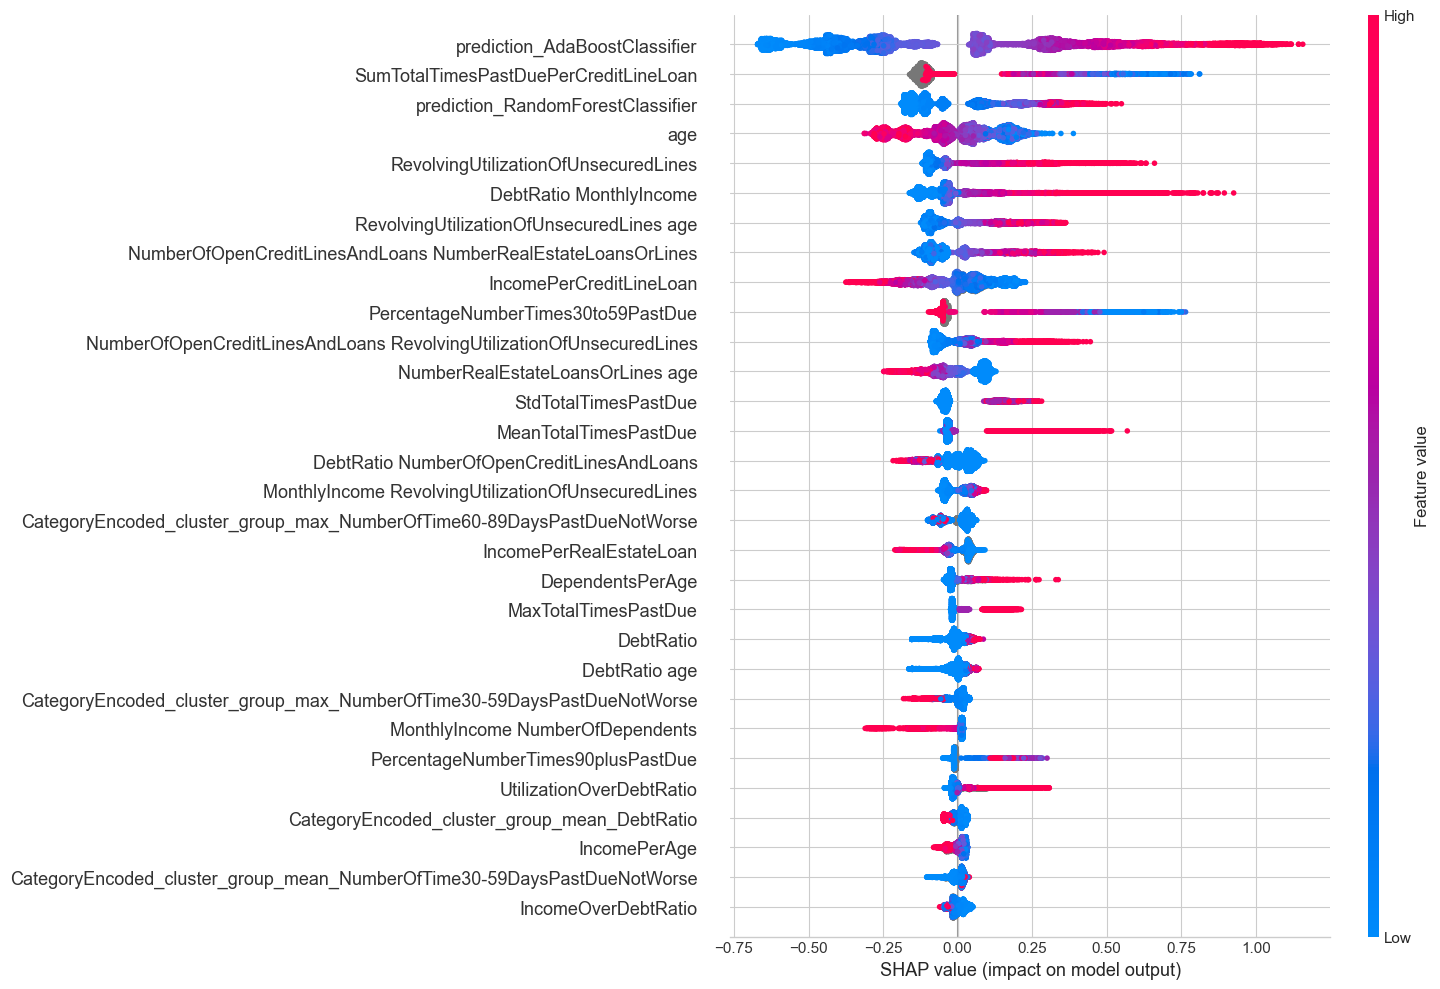

In [15]:

plot_shap(new_df, boruta_features)

### SHAP by risk band

The feature's impact will be estimated but the different subpopulations i.e risk bands from the lowest to the highest risk customers.

SHAP for risk band: A



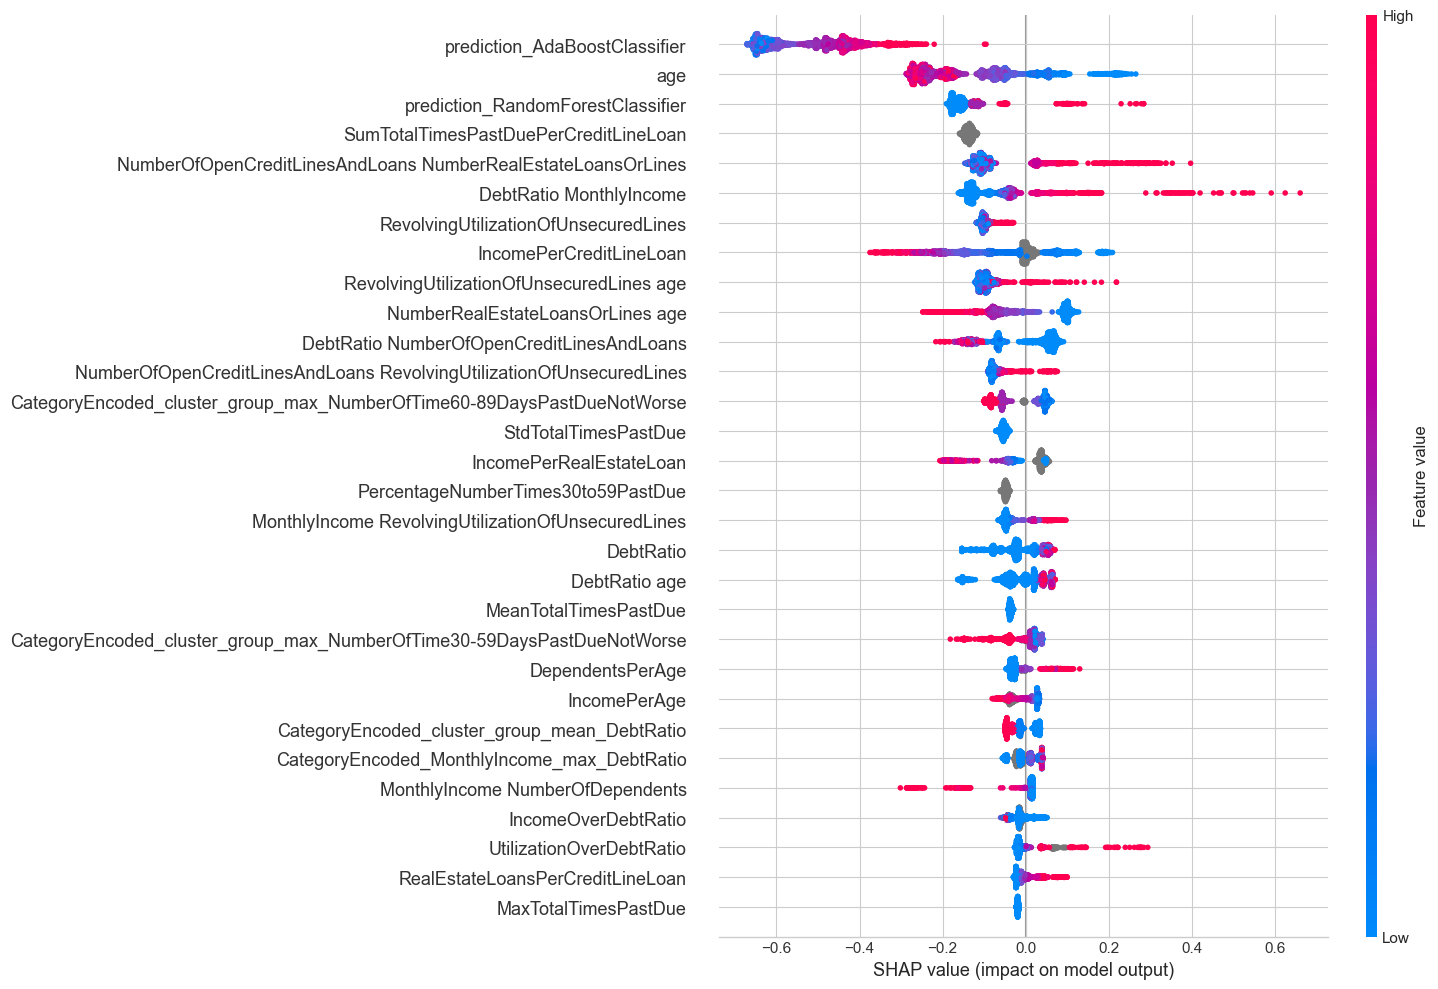

SHAP for risk band: B



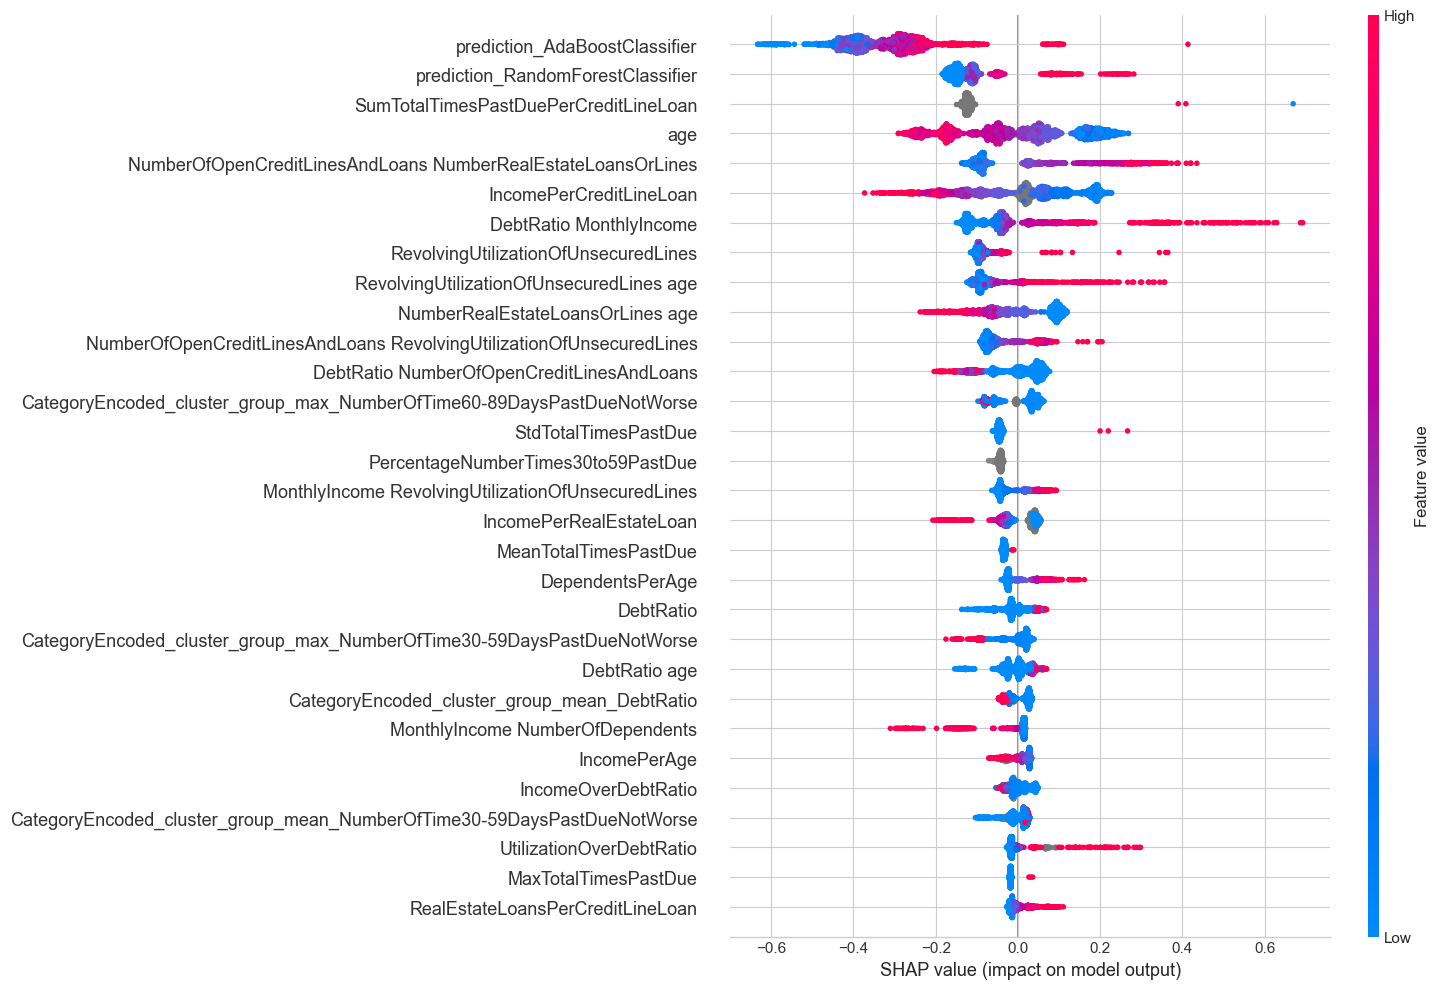

SHAP for risk band: C



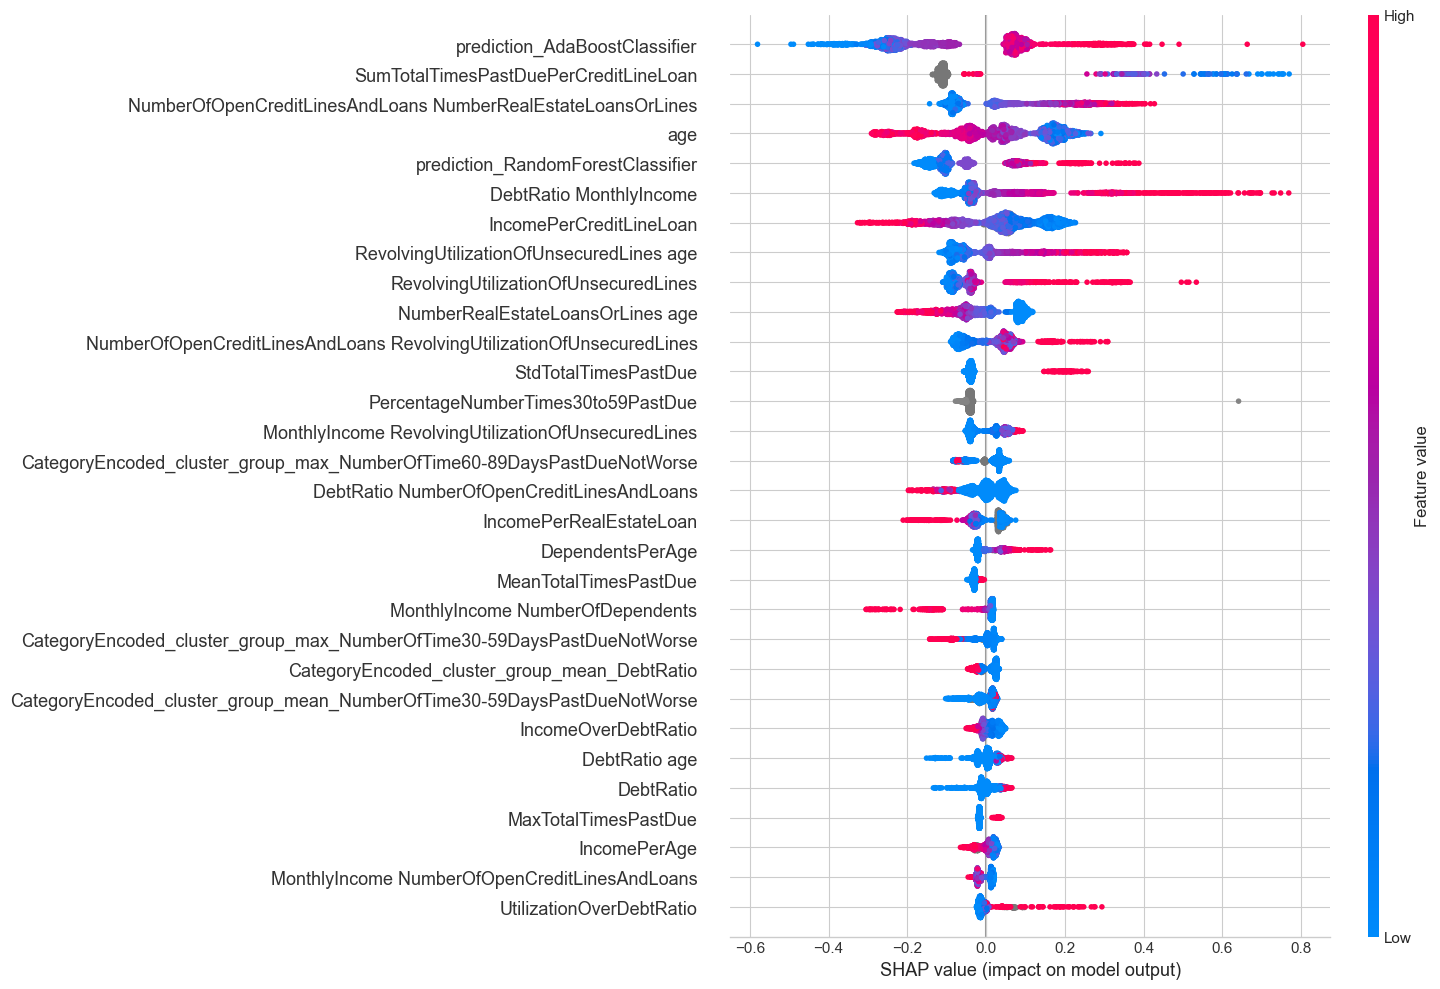

SHAP for risk band: D



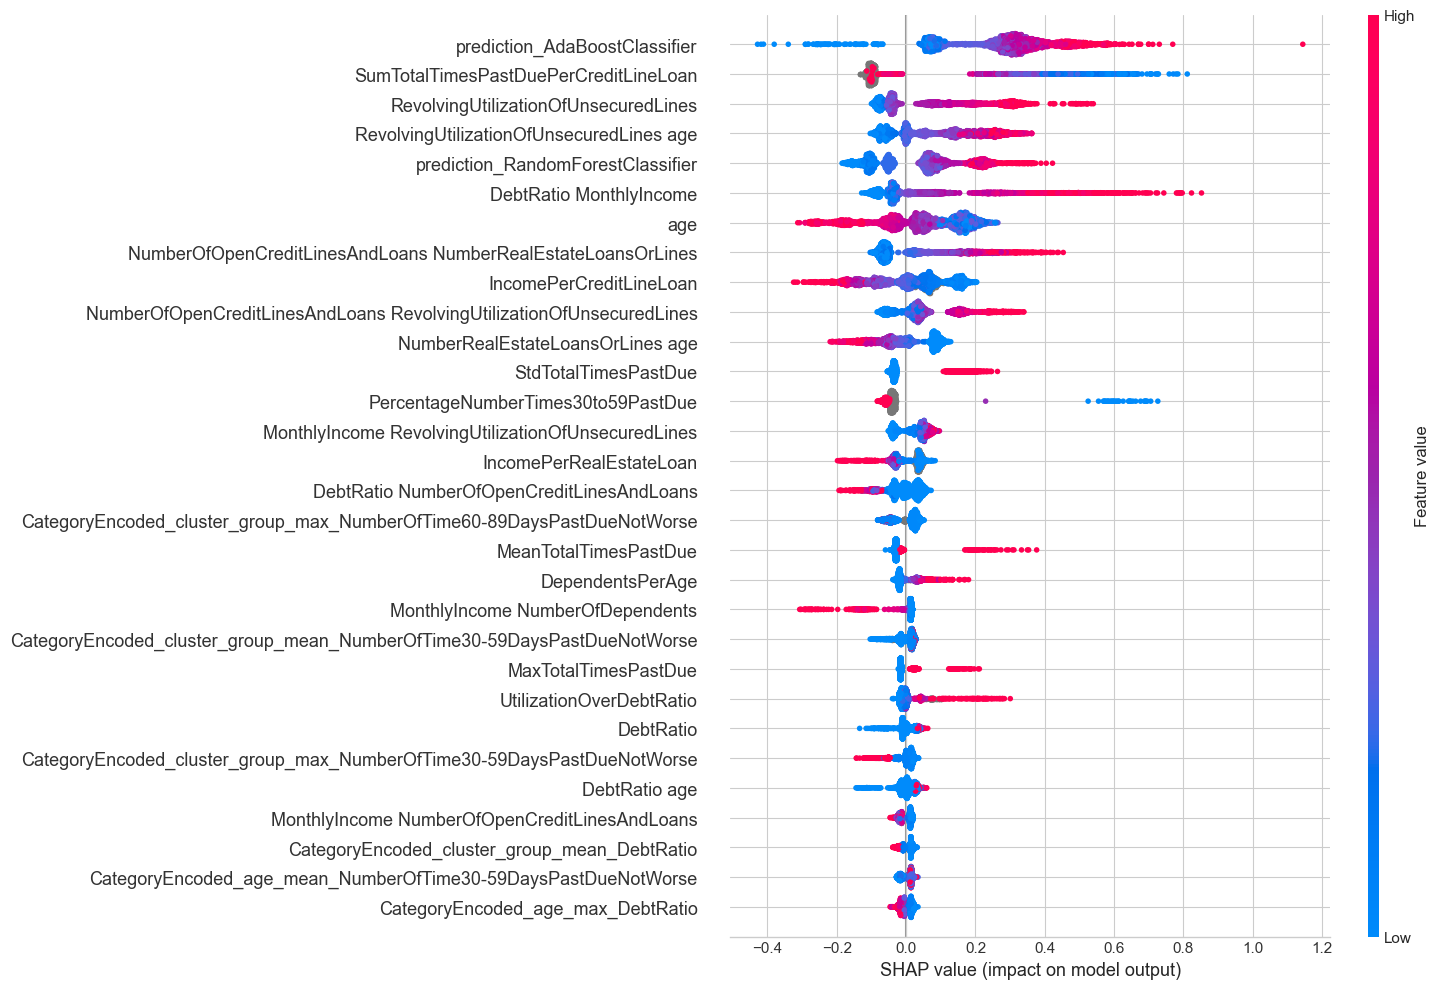

SHAP for risk band: E



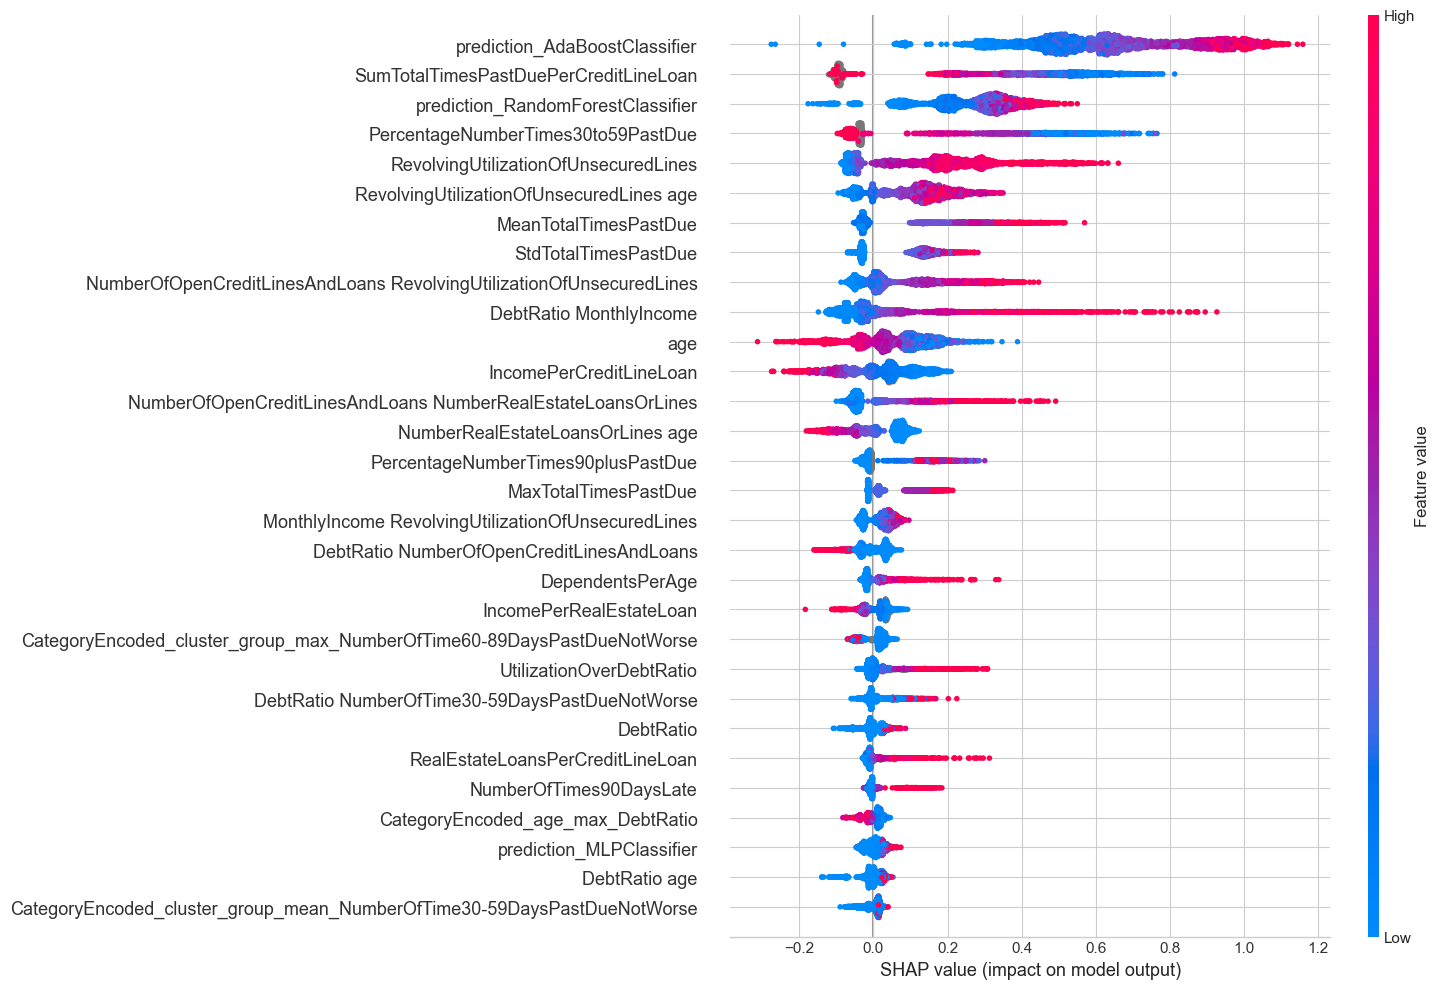

In [16]:

for cat in sorted(new_df.risk_band.unique()):
    aux = new_df[new_df.risk_band.isin([cat])]
    print(f"SHAP for risk band: {cat}\n")
    plot_shap(aux, boruta_features)

### SHAP by data source

By taking advantage of the additive property of SHAP values, we can calculate the average contribution by subset of features. In this case we are to focus on the different data sources that were used to create the input features.

In [17]:
from utils.feature_selection_lists import  boruta_features
from utils.features_lists import base_features , added_features

original_fetures = [x for x in base_features if x in boruta_features]
engineered_fetures = [x for x in added_features if x in boruta_features]

assert len(boruta_features) == len(original_fetures + engineered_fetures)
                                

avg_shap_df = pd.DataFrame(np.abs(np.vstack(new_df.shap_values)).mean(axis = 0), index = boruta_features, columns = ["avg_shap"])

In [18]:

condlist = [avg_shap_df.index.isin(original_fetures), 
           avg_shap_df.index.isin(engineered_fetures)
           ]

choicelist = ['original',
              'engineered'
             ]

avg_shap_df["feature_group"] = np.select(condlist, choicelist)

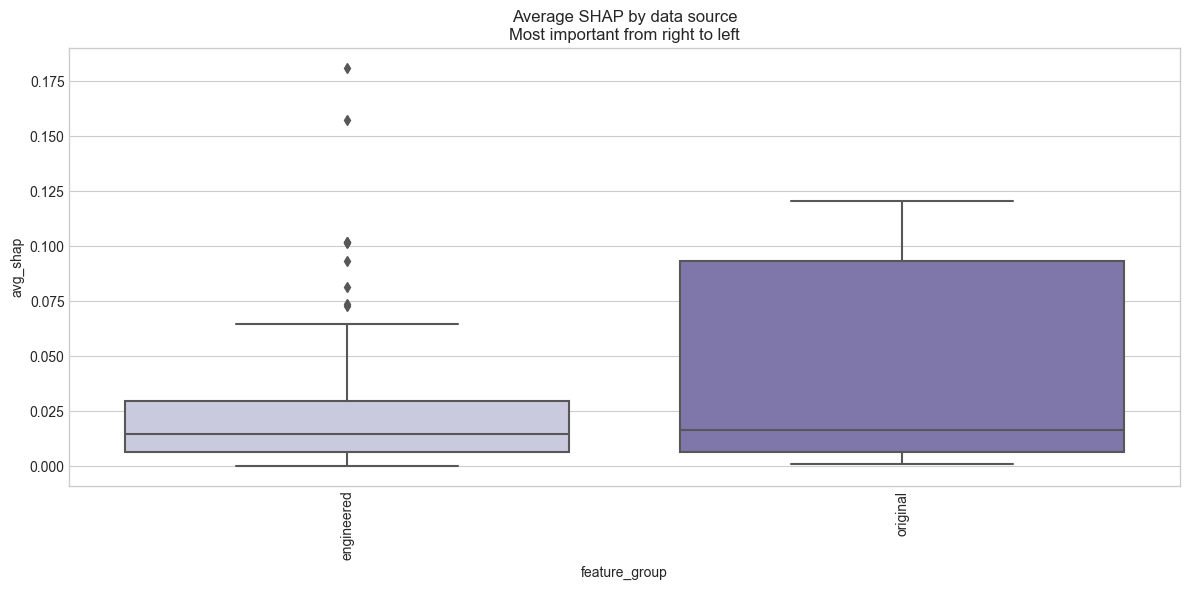

In [19]:
fig, ax = plt.subplots(figsize = (12,6))
order = avg_shap_df.groupby("feature_group").avg_shap.mean().sort_values().index.tolist()
ax = sns.boxplot(avg_shap_df.sort_values(by = "avg_shap").iloc[:-1],
            x = "feature_group",
            y = "avg_shap", order=order,palette = "Purples")
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.title(f"Average SHAP by data source\nMost important from right to left")
plt.tight_layout();